In [1]:
import pnl
import scraper
from db_initialize import conn
from datetime import date

dropping tables
Loading Hours tables


## 1. Scrape the Auction Result

In [2]:
auction_result = scraper.get_ftr_auction_result()

Creating a Session.
Requesting the url.
Processing the page.
CSV download list created.
Start Combining CSVs.
(4636, 16) monthly 202204
(4636, 17)
(3353, 16) long_term_2 2022
(40236, 17)
(3326, 16) long_term_1 2022
(39912, 17)
(5576, 16) monthly 202203
(5576, 17)
(5690, 16) monthly 202202
(5690, 17)
(7834, 16) monthly 202201
(7834, 17)


## 2. Generate the price History

In [3]:
input_date = date(2022,3,1)
daily_da_lmp = pnl.f_get_monthly_settlement_price(input_date)

Scraping Data...
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220301.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220302.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220303.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220304.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220305.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220306.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220307.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220308.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220309.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220310.csv
(28992, 10)
htt

## 3. Insert the data into the database

In [4]:
daily_da_lmp.to_sql('IsoneDailyDaLmp',con = conn, index = False, if_exists = 'append')
auction_result.to_sql('FtrAuctionResult',con = conn, index = False, if_exists = 'append')

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


## 4. Calculate the PnL for Mar22 settlement

In [5]:
mar_pnl = pnl.f_calculate_monthly_ftr_settlement_pnl('2022-03-01',conn)
print(mar_pnl.shape)

(290888, 23)


In [6]:
#aggregate
mar_pnl_by_company = mar_pnl[['Customer Name','Pnl']].groupby('Customer Name').sum().reset_index()

## 5. Calculate the PnL for Apr22 auction

In [7]:
apr_pnl = pnl.f_calculate_monthly_ftr_mta_pnl('monthly_202204',conn)
print(apr_pnl.shape)

(9612, 20)


In [8]:
apr_pnl_by_company = apr_pnl[['Customer Name','Pnl']].groupby('Customer Name').sum().reset_index()

## 6. Quick Visualization

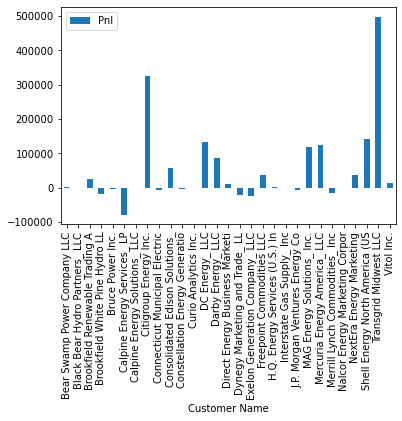

In [12]:
mar_pnl_by_company.plot.bar(x = 'Customer Name',y = 'Pnl')

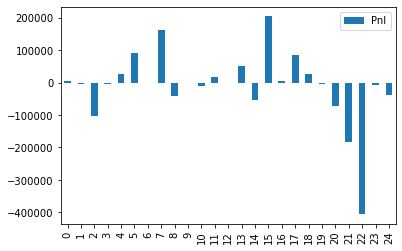

In [10]:
apr_pnl_by_company.plot.bar()